# Study Data from Sensors

- Load Time-Series
- Study global pattern (daily and over whole period)
- Showcase Air quality over the time with nice plots
- Infer relations between data and human activity

### Load dataset

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.style as style

plt.style.use('ggplot')

In [30]:
df = pd.read_csv('dataset.csv', parse_dates=["created_at"])

c:\users\antoi\miniconda3\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname CET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [31]:
columns_to_keep  = ['created_at']
columns_to_keep += ['field' + str(i) for i in range(1,9)]

In [32]:
df = df[columns_to_keep]

In [33]:
df.rename(columns={
    "created_at": "date",
        "field1": "temperature",
        "field2": "humidity",
        "field3": "pressure",
        "field4": "gas_resistance",
        "field5": "iaq",
        "field6": "iaq_accuracy",
        "field7": "static_iaq",
        "field8": "co2_equivalent"    
}, inplace=True)

In [34]:
df.set_index('date', inplace=True)

### Perform basic analysis

In [35]:
print(f"Data Available from {df.index.min()} to {df.index.max()}")
print(f"Row count {len(df.index)}")
print("Missing Values per column:")
df.isnull().sum() # total number of rows where the value is null

Data Available from 2020-11-26 02:11:56 to 2021-01-01 08:16:33
Row count 175050
Missing Values per column:


temperature       0
humidity          0
pressure          0
gas_resistance    0
iaq               0
iaq_accuracy      0
static_iaq        0
co2_equivalent    0
dtype: int64

In [36]:
# to have a look at the distribution (statistic)
df.describe()

,temperature,humidity,pressure,gas_resistance,iaq,iaq_accuracy,static_iaq,co2_equivalent
count,175050.000000,175050.000000,175050.000000,1.750500e+05,175050.000000,175050.000000,175050.000000,175050.000000
mean,22.877299,44.234226,99048.953111,4.413853e+05,114.549150,2.275578,104.382432,1107.185116
std,1.064398,10.109587,1131.310606,2.071504e+05,64.947378,0.951809,81.876964,768.081510
min,13.930000,22.920000,96050.000000,2.103100e+04,0.000000,0.000000,0.000000,400.000000
25%,22.160000,37.690000,98075.000000,2.849310e+05,56.870000,1.000000,41.632500,566.540000
50%,22.800000,44.580000,99386.000000,3.918220e+05,109.105000,3.000000,85.680000,856.775000
75%,23.520000,51.080000,99934.000000,5.748730e+05,162.690000,3.000000,133.070000,1330.667500
max,28.100000,78.330000,100643.000000,1.023503e+06,500.000000,3.000000,618.180000,6181.760000


We can notice that **min(static_iaq)** and **min(iaq)** is **0**

This is due to the fact that the Bosch sensor needs to be calibrated before giving a correct value.
As a result, we should :
- **remove** those rows (ideally but seems negligeable)
- take care of the *iaq_accuracy* column that is very important

In [37]:
mask = (df["iaq"] == 0)
print(f"{len(df[mask].index)} rows with value 0 as IAQ measure")

148 rows with value 0 as IAQ measure


<AxesSubplot:xlabel='date'>

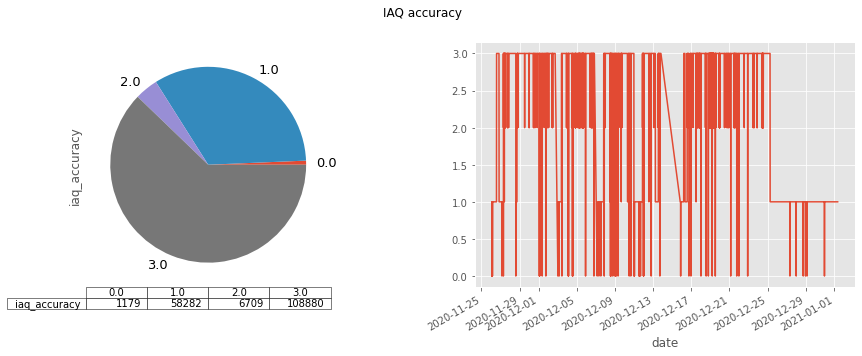

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('IAQ accuracy')

df.groupby("iaq_accuracy")["iaq_accuracy"].count().plot.pie(ax=axs[0],table=True, fontsize=13)
df["iaq_accuracy"].plot(ax=axs[1])

2/3 of the rows were retrieved with the sensor at its best calibration state, we can perform our analysis on these data only and filter out when IA_accuracy is lower than 2

In [39]:
# filtering
mask = (df["iaq_accuracy"] > 1)
df   = df[mask]

In [40]:
df.head(5)

,temperature,humidity,pressure,gas_resistance,iaq,iaq_accuracy,static_iaq,co2_equivalent
date,,,,,,,,
2020-11-26 13:54:19,23.19,38.53,99914.0,159499.0,262.18,2.0,163.17,1631.74
2020-11-26 13:54:34,23.21,38.06,99911.0,165929.0,243.56,2.0,153.66,1536.61
2020-11-26 13:54:52,23.22,37.86,99914.0,166749.0,233.16,2.0,147.51,1475.09
2020-11-26 13:55:07,23.25,38.14,99913.0,161329.0,250.00,2.0,157.70,1577.05
2020-11-26 13:55:25,23.28,38.41,99911.0,159048.0,254.19,2.0,162.20,1622.01


<AxesSubplot:title={'center':'Data count per day'}>

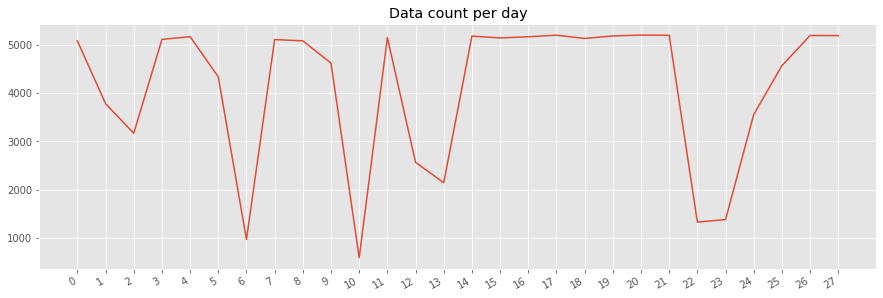

In [41]:
day = pd.to_timedelta(df.index.day, unit='D')

day_count = (df.index.max() - df.index.min()).days
day_list  = [i for i in range(day_count)]

data_per_day = df["temperature"].groupby(day).count()
data_per_day.plot(x=day_list,
                  use_index=False,
                  title="Data count per day",
                  xticks=day_list, 
                  figsize=(15,5))

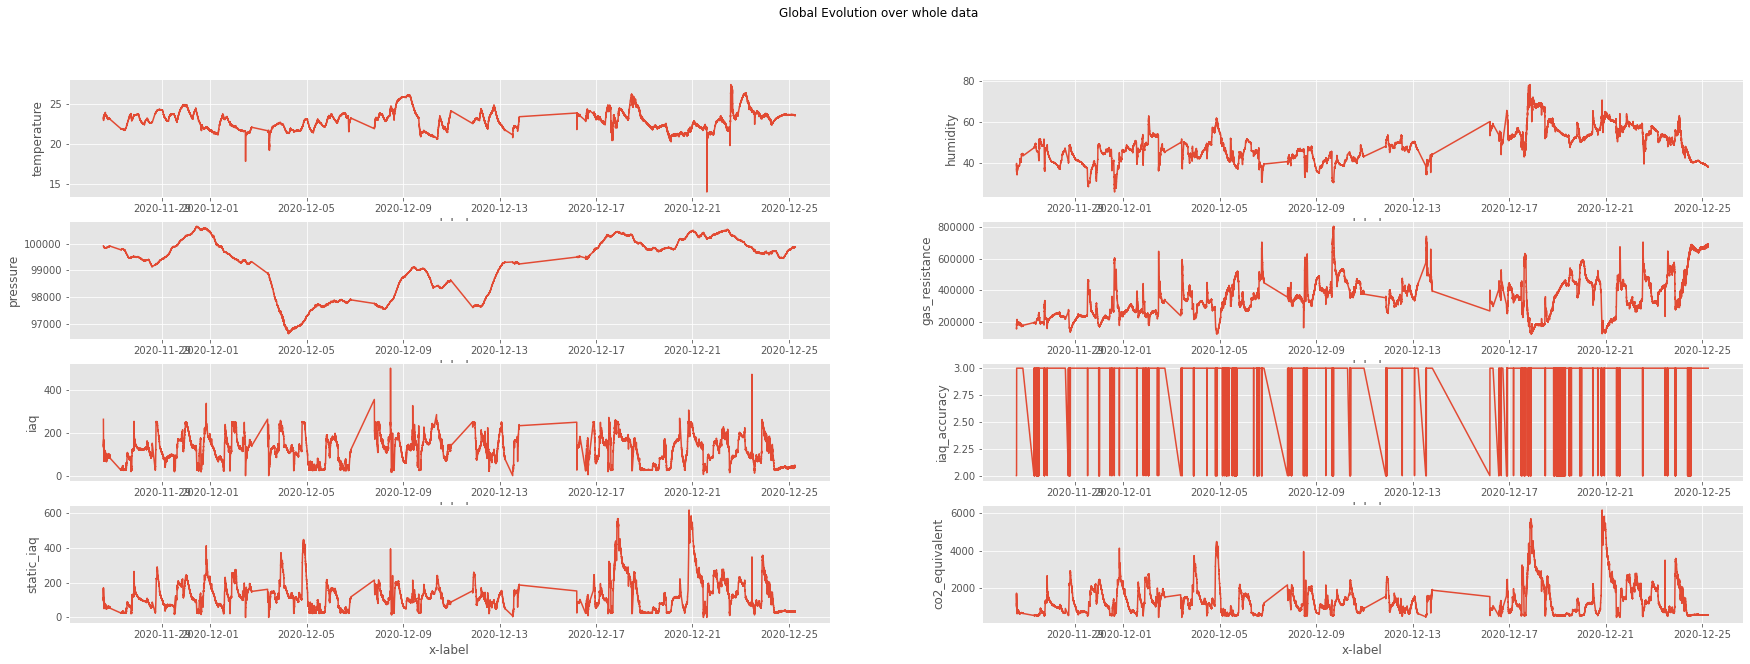

In [42]:
nb_plots = len(df.columns)

fig, axs = plt.subplots(4, 2, figsize=(30,10))
fig.suptitle('Global Evolution over whole data')

i = 0
for ax in axs.flat:
    column = df.columns[i]
    ax.set(xlabel='x-label', ylabel=column)
    ax.plot(df[column])
    i += 1

array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'pressure'}>],
       [<AxesSubplot:title={'center':'gas_resistance'}>,
        <AxesSubplot:title={'center':'iaq'}>,
        <AxesSubplot:title={'center':'iaq_accuracy'}>],
       [<AxesSubplot:title={'center':'static_iaq'}>,
        <AxesSubplot:title={'center':'co2_equivalent'}>, <AxesSubplot:>]],
      dtype=object)

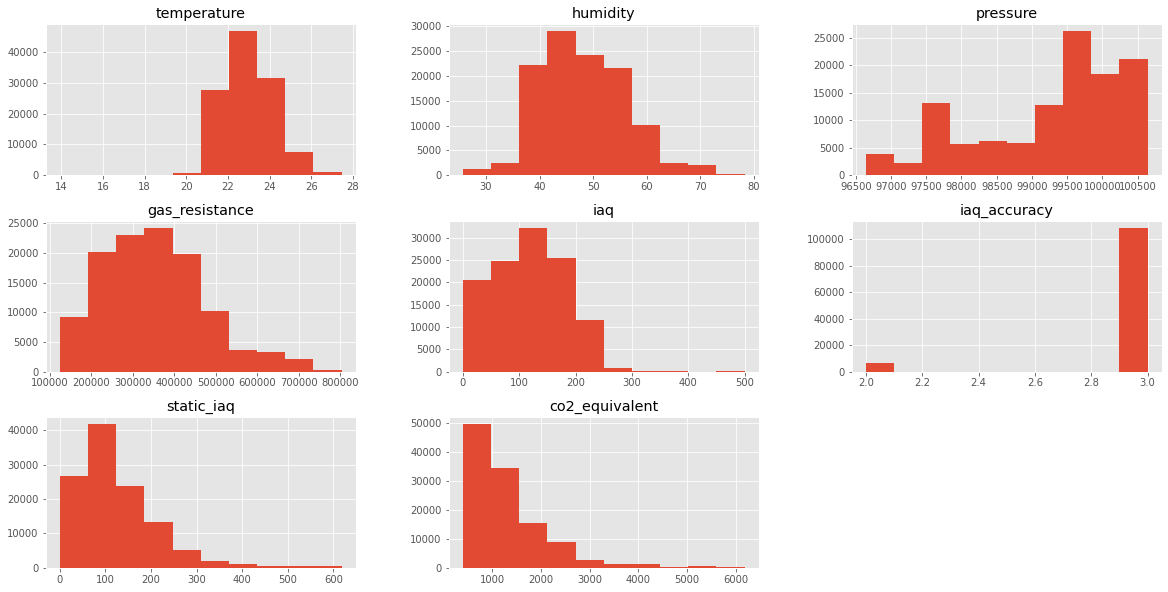

In [43]:
df.hist(figsize=(20,10))

- static_iaq / co2_equivalent / iaq may need a gaussian correction to make sure our hypothesis over the values are correct ?

## Group rows per hours to see if general tendancy

In [44]:
hour = pd.to_timedelta(df.index.hour, unit='H')
per_hour = df.groupby(hour).mean()

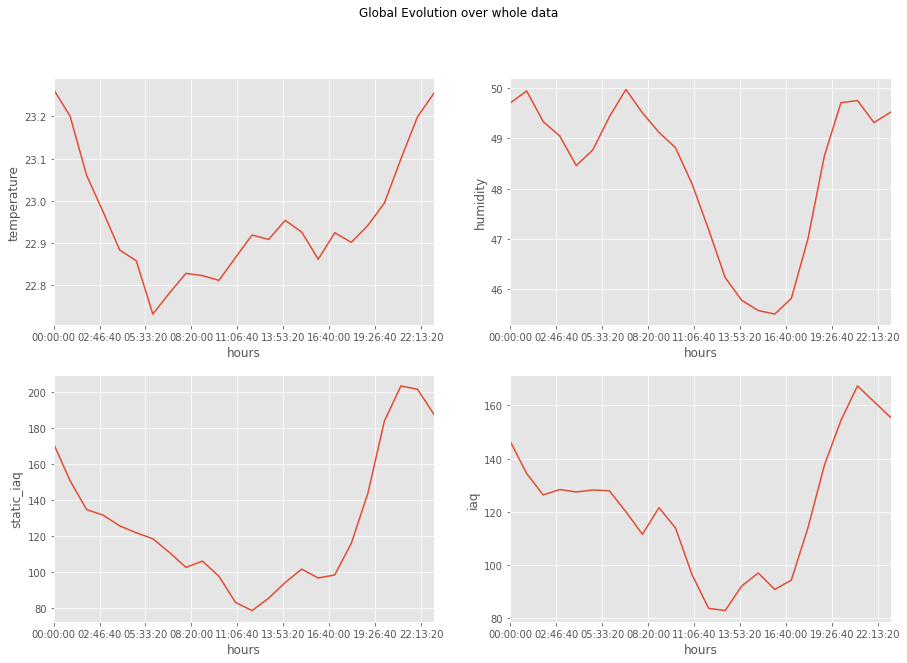

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Global Evolution over whole data')

per_hour = per_hour[["temperature", "humidity", "static_iaq", "iaq"]]

i = 0
for ax in axs.flat:
    column = per_hour.columns[i]
    per_hour[column].plot(ax=ax)
    ax.set(xlabel='hours', ylabel=column)
    i += 1

- Temperature : we observe that on average, temperature is higher during the evening and fall down starting from 1 a.m
- Humidity : we observe that on average, humidity is rising during the evening and fall down starting from 8 a.m
- IOQ and static_IAQ both follow a quite similar pattern => let's plot the same graph with the std

In [46]:
hour = pd.to_timedelta(df.index.hour, unit='H')
df_temp = df["static_iaq"].groupby(hour).agg(["mean", "median", "std"]).reset_index()

(0.0, 440.0)

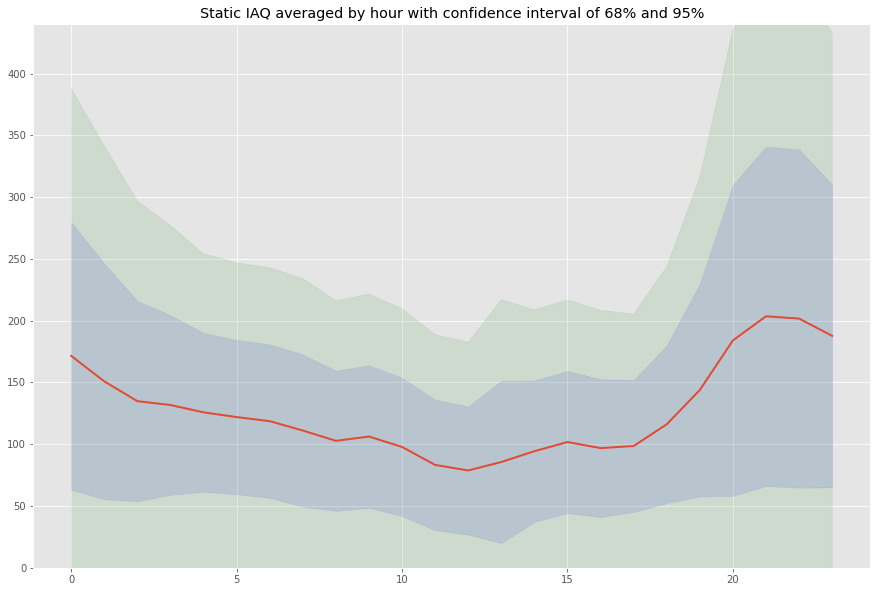

In [47]:
smooth_path    = df_temp["mean"]
path_deviation = df_temp["std"]

#Plotting:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Static IAQ averaged by hour with confidence interval of 68% and 95%")

#mean curve.
ax.plot(smooth_path, linewidth=2)

# std curves
ax.fill_between(path_deviation.index, (smooth_path-path_deviation), (smooth_path+path_deviation), color='b', alpha=.1)
ax.fill_between(path_deviation.index, (smooth_path-path_deviation*2), (smooth_path+path_deviation*2), color='g', alpha=.1)
plt.ylim([0, 440])

### Apply log1p to the column to make it more "gaussian"

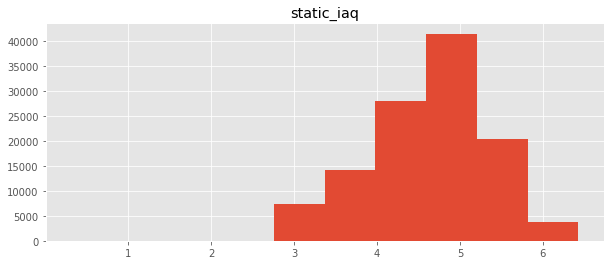

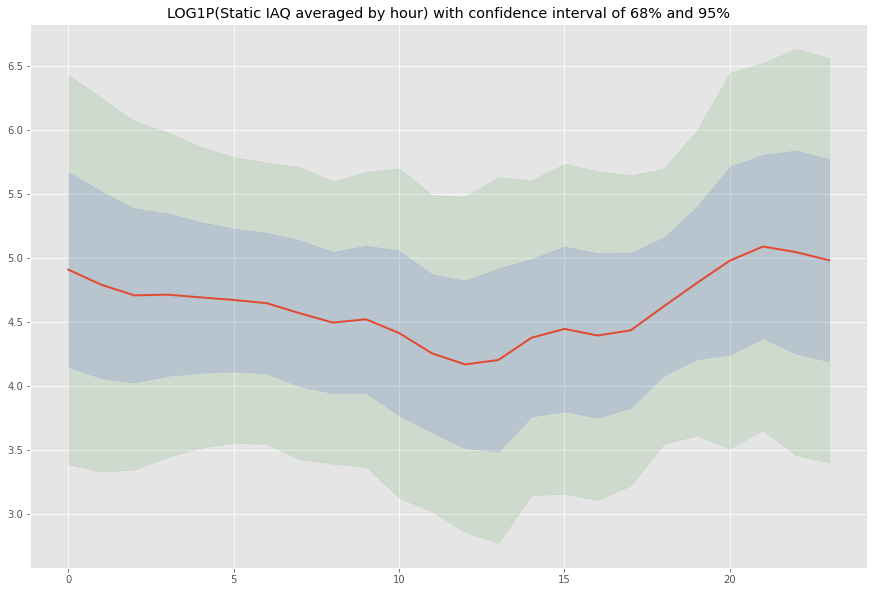

In [48]:
mask = df["static_iaq"] > 0
temp_log_static_iaq = pd.DataFrame(np.log1p(df[mask]["static_iaq"]), df[mask]["static_iaq"].index)
temp_log_static_iaq.hist(figsize=(10,4))

hour = pd.to_timedelta(temp_log_static_iaq.index.hour, unit='H')
df_temp = temp_log_static_iaq["static_iaq"].groupby(hour).agg(["mean", "median", "std"]).reset_index()

smooth_path    = df_temp["mean"]
path_deviation = df_temp["std"]

#Plotting:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("LOG1P(Static IAQ averaged by hour) with confidence interval of 68% and 95%")

#mean curve.
ax.plot(smooth_path, linewidth=2)

# std curves
ax.fill_between(path_deviation.index, (smooth_path-path_deviation), (smooth_path+path_deviation), color='b', alpha=.1)
ax.fill_between(path_deviation.index, (smooth_path-path_deviation*2), (smooth_path+path_deviation*2), color='g', alpha=.1)

### Study derivative

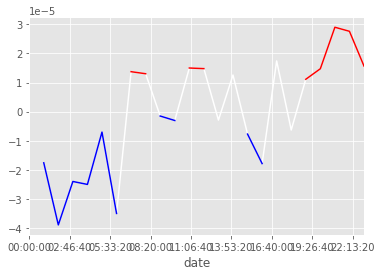

In [49]:
hour = pd.to_timedelta(df.index.hour, unit='H')
per_hour = df.groupby(hour).mean()

per_hour_diff_temp = per_hour['temperature'].diff() / per_hour.index.to_series().diff().dt.total_seconds()

per_hour_diff_temp.plot(color='w')

pos_signal = per_hour_diff_temp.copy()
neg_signal = per_hour_diff_temp.copy()

pos_signal[pos_signal <= 0] = np.nan
neg_signal[neg_signal > 0]  = np.nan

#plotting
plt.plot(pos_signal, color='r')
plt.plot(neg_signal, color='b')
plt.show()

## Group rows per days to see if general tendancy

In [50]:
day = pd.to_timedelta(df.index.day, unit='D')
per_day = df.groupby(day).mean()

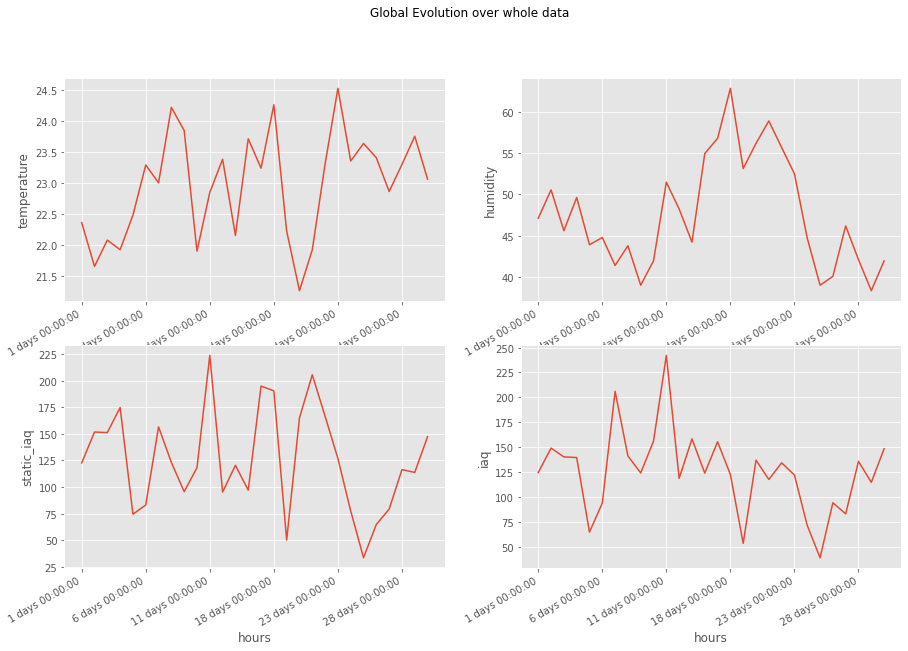

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Global Evolution over whole data')

per_day = per_day[["temperature", "humidity", "static_iaq", "iaq"]]

i = 0
for ax in axs.flat:
    column = per_day.columns[i]
    per_day[column].plot(ax=ax)
    ax.set(xlabel='hours', ylabel=column)
    i += 1

### Study Days by pollutions level

In [52]:
colors = ['black', 'purple',  'red', 'orange', 'yellow', 'green']
orders = ['Hazardous', 'Very Unhealthy', 'Unhealthy', 'Unhealthy for Sensitive Groups', 'Moderate', 'Good']

colormap = dict(zip(orders, colors))
colormap

{'Hazardous': 'black',
 'Very Unhealthy': 'purple',
 'Unhealthy': 'red',
 'Unhealthy for Sensitive Groups': 'orange',
 'Moderate': 'yellow',
 'Good': 'green'}

In [53]:
# create a new column to classify IAQ values in groups
df['iaq_categories'] = pd.cut(x=df['iaq'],
                                bins=[0, 50, 100, 150, 200, 300, 500],
                                labels=["Good",
                                        "Moderate",
                                        "Unhealthy for Sensitive Groups",
                                        "Unhealthy",
                                        "Very Unhealthy",
                                        "Hazardous"])

In [54]:
df['iaq_categories'].value_counts()

Unhealthy for Sensitive Groups    32288
Unhealthy                         25504
Moderate                          24728
Good                              20573
Very Unhealthy                    12417
Hazardous                            29
Name: iaq_categories, dtype: int64

array([<AxesSubplot:ylabel='iaq_categories'>], dtype=object)

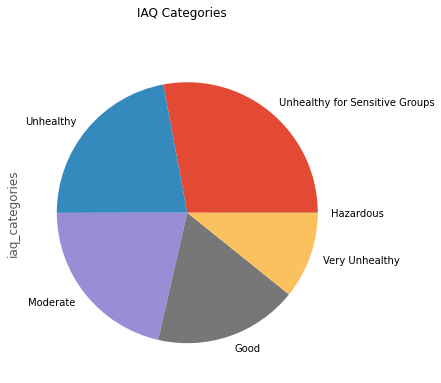

In [55]:
fig, axs = plt.subplots(figsize=(6,6))
fig.suptitle('IAQ Categories')

df2 = df['iaq_categories'].value_counts()
df2.plot.pie(subplots=True)

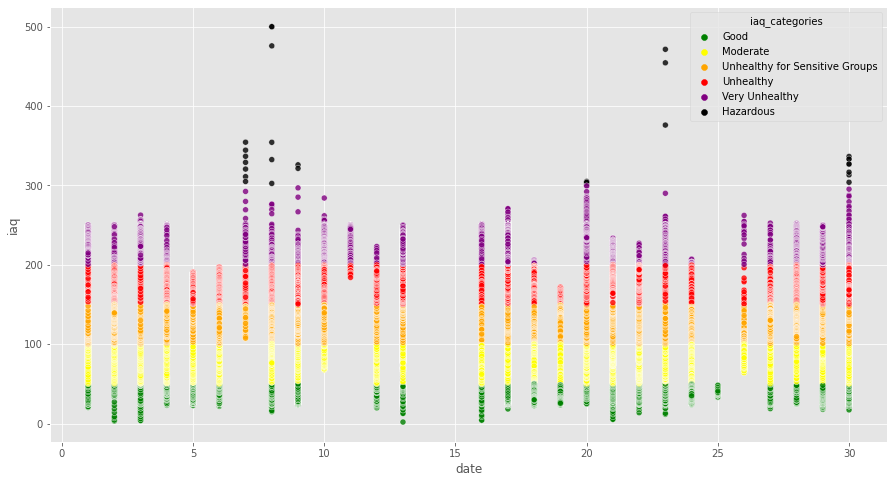

In [56]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=df, x=df.index.day, y=df['iaq'], hue='iaq_categories', palette=colormap, alpha=0.8)